In [1]:
import jax.random
%cd "~/code/snet/moses-incons-pen-xp"
%load_ext autoreload
%autoreload

/home/xabush/code/snet/moses-incons-pen-xp


In [2]:
# import jax.numpy as np
import numpy as np
import jax
import jax.random as rng
import jax.numpy as jnp
import numpyro as npyro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
import arviz as az
import scipy
import scipy.stats as st
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from notebooks.variable_selection.MosesEstimator import *
import warnings
warnings.filterwarnings('ignore')

In [19]:
### Python version of Jonathan's code to generate synth network
def gen_synth_net(num_feats, p=0.3):
    J = np.zeros((num_feats, num_feats))
    for i in range(num_feats):
        for j in range(i+1, num_feats):
            u = np.random.uniform()
            if u < p:
                r = st.halfnorm().rvs()
                # r = 1
                J[i, j] = r
                J[j, i] = r

    return J

def samples_to_feats(samples):
    feats = []
    for i in range(samples.shape[0]):
        feat_idx = list(np.nonzero(samples[i])[0])
        if len(feat_idx) == 0 or feat_idx in feats: continue
        feats.append(feat_idx)
    return feats

def rank_by_mi(samples, J, X, Y, eta=1.0, B=1.0):
    samples_c = samples.reshape((samples.shape[0]*samples.shape[1], samples.shape[2]))
    samples_unq = np.unique(samples_c, axis=0)
    energy_vals = [bmm_energy(samples_unq[i], J, eta=eta) for i in range(samples_unq.shape[0])]
    feats = samples_to_feats(samples_unq)
    mi_scores = []
    for eng, feat in zip(energy_vals, feats):
        s_score = 0.0
        for f in feat:
            mi = mutual_info_score(Y, X[:,f])
            s_score += mi

        mi_scores.append(s_score - B*eng)

    idxs = np.argsort(np.array(mi_scores))[::-1]
    feats = list(np.array(feats)[idxs])

    return feats, np.sort(np.array(mi_scores))[::-1]

def rank_by_cond_prob(samples, J, X_train, y_train, energy_fn, eta=1.0):
    samples_c = samples.reshape((samples.shape[0]*samples.shape[1], samples.shape[2]))
    samples_unq = np.unique(samples_c, axis=0)
    prob_vals = [np.exp(-energy_fn(samples_unq[i], J, X=X_train, Y=y_train, eta=eta)) for i in range(samples_unq.shape[0])]
    idx = np.argsort(np.array(prob_vals))[::-1]
    samples_unq = samples_unq[idx]
    feats = samples_to_feats(samples_unq)
    return feats

def get_rand_feats(p, n=100):
    feats = []
    for i in range(n):
        idx = np.random.randint(0, 2, size=p)
        feats.append(list(np.nonzero(idx)[0]))

    return feats

def plot_energy_model(J, net_energy, net_spins, samples, energy_fn, X=None, Y=None, eta=1.0):
    chains, num_samples, n_dim = samples.shape
    samples = samples.reshape((chains*num_samples, n_dim))
    energy_vals = [energy_fn(samples[i], J, X, Y, eta=eta) for i in range(samples.shape[0])]
    prob_vals = [np.exp(-e) for e in energy_vals]
    fig, ax = plt.subplots(2, 2, figsize=(24, 18))
    s = np.arange(1, net_energy.shape[1] + 1)
    t = np.arange(1, samples.shape[0] + 1)
    for i in range(net_energy.shape[0]):
        ax[0, 0].plot(s, net_energy[i])
        ax[1, 0].plot(s, net_spins[i])

    ax[0, 1].plot(t, energy_vals)
    ax[1, 1].plot(t, prob_vals)

    ax[0, 0].set(title="Net Energy over Time", xlabel="Time", ylabel="$E(\gamma)$")
    ax[1, 0].set(title="Net spins over Time", xlabel="Time", ylabel="Sping")
    ax[0, 1].set(title="Energy for 10000 samples", xlabel="i", ylabel="$E(\gamma)$")
    ax[1, 1].set(title="Probability for 10000 samples", xlabel="i", ylabel="$p(\gamma)$")

    return energy_vals, prob_vals

def logistic(x):
    return 1/(1 + jnp.exp(-x))

def jax_prng_key():
    return jax.random.PRNGKey(np.random.randint(int(1e5)))

def hamm(a,b):
    return len(np.nonzero(a != b)[0])


def generate_potential_energy_fn(X, y, J, sigma, mu):
    X = jax.device_put(X)
    y = jax.device_put(y)
    J = jax.device_put(J)
    mu = jax.device_put(mu)
    # sigma = jax.device_put(sigma)
    beta_dist = distrax.MultivariateNormalFullCovariance(sigma)
    def potential_energy(gamma, beta):
        gamma_f = gamma.astype(jnp.float32)
        # beta_prior_potential = jnp.sum(
        #     0.5 * jnp.log(2 * jnp.pi * sigma ** 2) + 0.5 * beta ** 2 / sigma ** 2
        # )
        beta_prior_potential = beta_dist.log_prob(beta)
        probs = 1 / (
                1 + jnp.exp(-jnp.dot(jnp.dot(X, jnp.diag(gamma_f)), beta))
        )
        likelihood_potential = -jnp.sum(
            y * jnp.log(probs + 1e-12) + (1 - y) * jnp.log(1 - probs + 1e-12)
        )

        gamma_potential = -0.5*jnp.dot(jnp.dot(gamma_f.T, J), gamma_f) + mu*jnp.sum(gamma_f)

        return beta_prior_potential + likelihood_potential + gamma_potential

    return potential_energy

In [61]:

from notebooks.variable_selection.util import load_bmm_files
seeds, data_dfs, net_dfs, feats = load_bmm_files("data/bmm_data_thr_2/")
print(f"seeds - {seeds}")
seed_idx = 2
np.random.seed(seeds[seed_idx])
J = net_dfs[seed_idx].to_numpy()
J_pos = np.abs(net_dfs[seed_idx].to_numpy())
J_pos[J_pos > 0.0] = 1.0
L = scipy.sparse.csgraph.laplacian(J_pos, normed=True)
# L = torch.from_numpy(L)
df = data_dfs[seed_idx]
X, y = df[df.columns.difference(["y"])].to_numpy().astype(np.float_), df["y"].to_numpy().astype(np.float_)
p = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seeds[seed_idx], shuffle=True, stratify=y)
key = rng.PRNGKey(seed_idx)
# X_train, X_test, y_train, y_test = X[:150], X[:-150], y[:150], y[:-150]
# X_train, y_train = X_train.to_numpy().astype(np.float64), y_train.to_numpy().astype(np.float64)
# X_test, y_test = X_test.to_numpy(), y_test.to_numpy()
print(f"causal feats for seed - {seeds[seed_idx]} - {np.array(feats[seed_idx]) - 1}")


seeds - [82, 91, 13, 92, 64, 10, 28, 55, 96, 97]
causal feats for seed - 13 - [75 65 51 89 17]


In [5]:
import numpy as np
import numba

@numba.njit(nogil=True)
def quad_prod(x, A):
    return ((x.T @ A) @ x)

@numba.njit(nogil=True)
def bmm_energy(gamma, G, X=None, Y=None, eta=1):
    return eta*(-quad_prod(gamma, G) + np.sum(gamma))

@numba.njit(nogil=True)
def bmm_energy_cond(gamma, G, X=None, Y=None, eta=1.0):

    return eta*(-quad_prod(gamma, G) + np.sum(gamma)) + np.sum((1 - Y) * (X @ gamma))

@numba.njit(nogil=True)
def bmm_energy_cond_2(gamma, G, X=None, Y=None, eta=1.0):

    return eta*(-quad_prod(gamma, G) + np.sum(gamma)) + np.sum((1 - Y) * (X @ gamma))

@numba.njit(nogil=True)
def metropolis(J, times, energy_fn, X=None, Y=None, c=5, n=100, eta=1.0):
    net_spins = np.zeros((c, times))
    net_energy = np.zeros((c, times))
    N = J.shape[0]
    samples = np.zeros((c, n, N))
    for j in range(c):
        init_state = np.random.randint(0, 2, size=N)
        init_state = init_state.astype(np.float_)
        energy = energy_fn(init_state, J, X, Y, eta)
        curr_st = init_state.copy()
        for t in range(0,times):
            # 2. pick random point on array and flip spin
            i = np.random.randint(0, N)
            prev_st = curr_st.copy()
            E_prev = energy_fn(prev_st, J, X, Y, eta=eta)
            val = np.abs(curr_st[i] - 1) # flip the current position
            # val = prev_st[i]*-1
            prev_st[i] = val
            # compute change in energy
            E_curr = energy_fn(prev_st, J, X, Y, eta=eta)
            # 3 / 4. change state with designated probabilities
            dE = E_curr-E_prev
            prob = np.exp(-dE)

            if (dE>0)*(np.random.random() < prob): ## accept the move lower probability state with probability p
                curr_st[i] = val
                energy += dE
            elif dE<=0: ##accept the move to higher probability state
                curr_st[i] = val
                energy += dE

            net_spins[j, t] = curr_st.sum()
            net_energy[j, t] = energy
            if times - t <= n:
                samples[j, n - (times - t)] = curr_st

    # samples = samples.reshape(c*n, N)

    return net_spins, net_energy, samples

### No conditional energy model

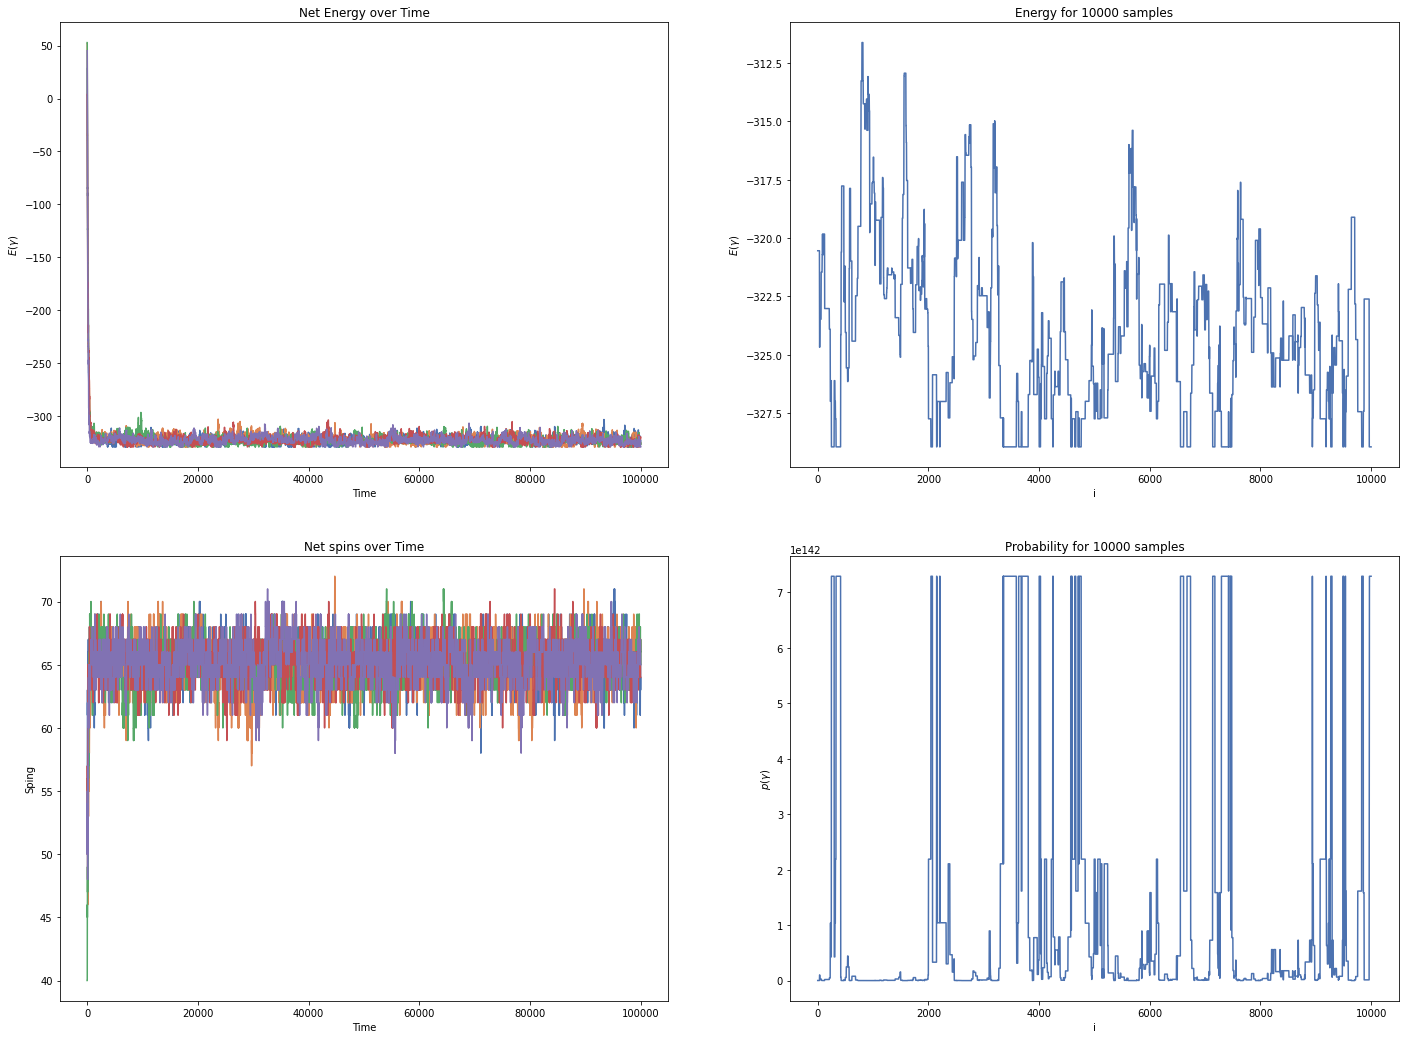

In [7]:

net_spins_1, net_energy_1, samples_1 = metropolis(J, int(1e5), bmm_energy, X=X_train, Y=y_train, n=2000)
energy_vals_1, prob_vals_1 = plot_energy_model(J, net_energy_1, net_spins_1, samples_1, bmm_energy)

### Conditional energy model


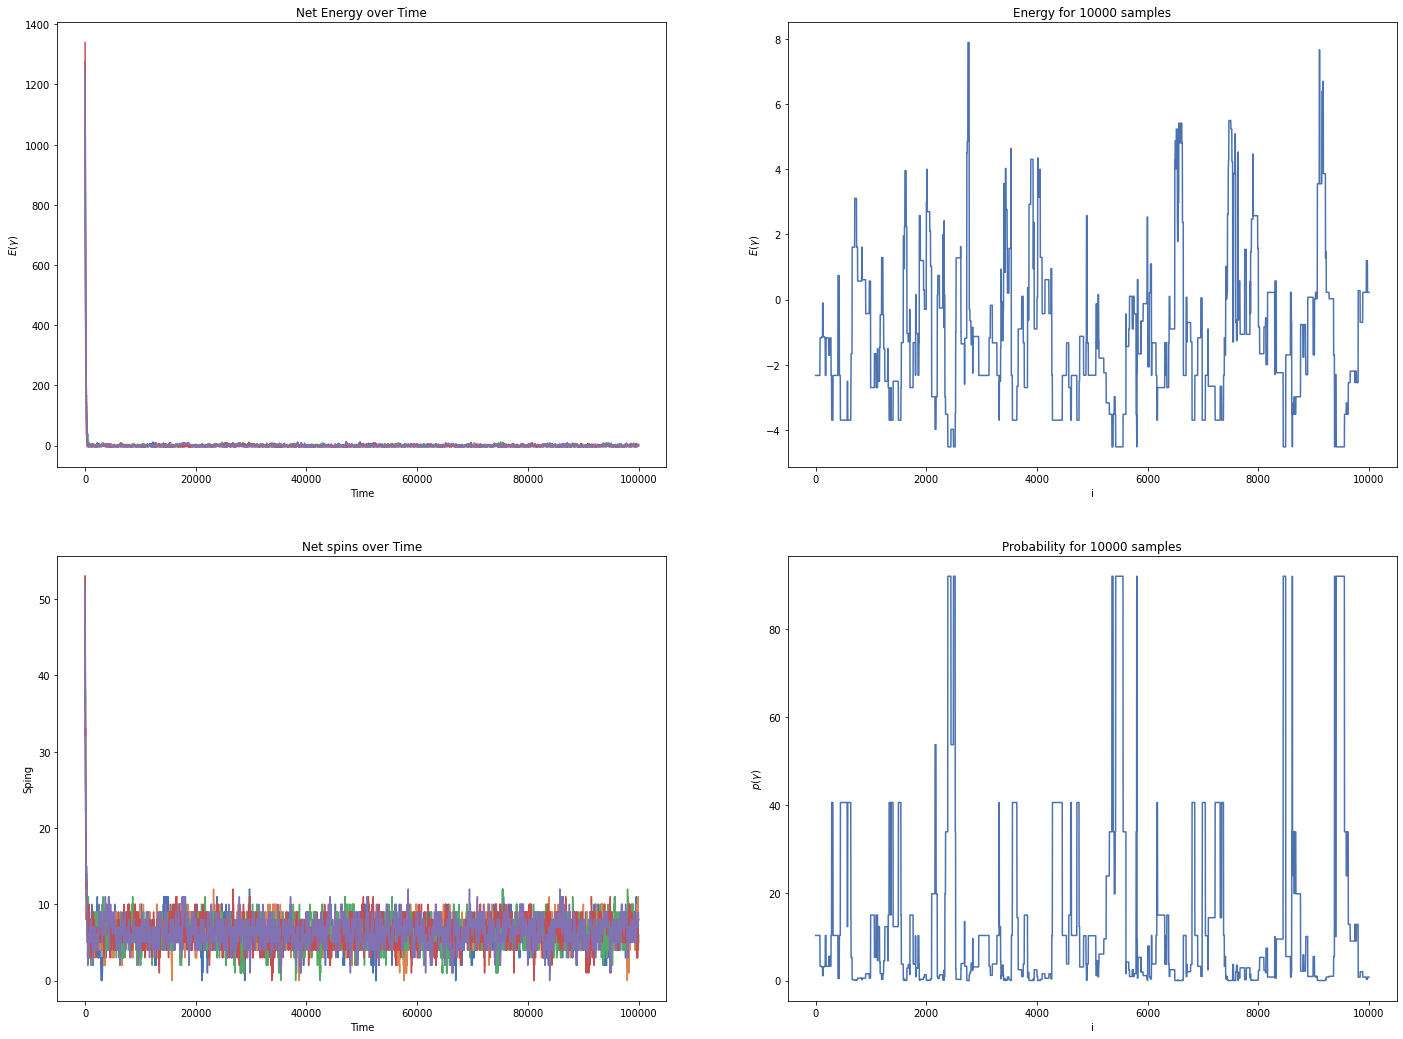

In [8]:

net_spins_2, net_energy_2, samples_2 = metropolis(J, int(1e5), bmm_energy_cond, X=X_train, Y=y_train, n=2000)
energy_vals_2, prob_vals_2 = plot_energy_model(J, net_energy_2, net_spins_2, samples_2, bmm_energy_cond, X_train, y_train)

#### MH Samples statistics

In [9]:
npyro.diagnostics.print_summary(samples_1)


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Param:0[1]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[2]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Param:0[3]      0.09      0.28      0.00      0.00      0.00       nan      1.33
 Param:0[4]      0.03      0.16      0.00      0.00      0.00       nan      1.04
 Param:0[5]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Param:0[6]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Param:0[7]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Param:0[8]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[9]      1.00      0.00      1.00      1.00      1.00       nan       nan
Param:0[10]      1.00      0.00      1.00      1.00      1.00       nan       nan
Param:0[11]    

In [10]:
npyro.diagnostics.print_summary(samples_2)


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[1]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[2]      0.30      0.46      0.00      0.00      1.00       nan      1.84
 Param:0[3]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[4]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[5]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[6]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[7]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[8]      0.00      0.00      0.00      0.00      0.00       nan       nan
 Param:0[9]      0.00      0.00      0.00      0.00      0.00       nan       nan
Param:0[10]      0.00      0.00      0.00      0.00      0.00       nan       nan
Param:0[11]    

In [13]:
feats_mi, mi_scores = rank_by_mi(samples_1, J, X_train, y_train)
len(feats_mi)

306

In [14]:
feats_cond = rank_by_cond_prob(samples_2, J, X_train, y_train, bmm_energy_cond)
len(feats_cond)

180

In [361]:

feats_rand = get_rand_feats(X_train.shape[1])

##### 1. MI Ranked top 100 feats

In [34]:
X_train[:,np.array(feats_mi[0])]

array([[1., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

In [ ]:

from notebooks.variable_selection.MosesEstimator import *
from sklearn.model_selection import cross_val_score

res_auc_mi = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_mi[:100])
res_auc_mi.to_csv("data/res_auc_mi_s_13.csv", index=False)
res_auc_mi

 95%|██████████████████████████████████▏ | 95/100 [1:02:58<03:16, 39.32s/it, m_tr=0.54, m_te=0.64, l_tr=0.51, l_te=0.49]

In [115]:
res_auc_mi.describe()

,moses_cv_score,moses_test_score,log_cv_score,log_test_score
count,100.000000,100.000000,100.000000,100.000000
mean,0.566032,0.604268,0.516747,0.487500
std,0.058946,0.050861,0.009377,0.011613
min,0.404405,0.475840,0.504486,0.481092
25%,0.532358,0.571429,0.507288,0.483193
50%,0.581465,0.606793,0.520874,0.485294
75%,0.606074,0.644783,0.522268,0.485294
max,0.668959,0.698529,0.536559,0.568627


In [46]:
res_auc_mi = pd.read_csv("data/res_auc_mi_s_13.csv")

In [ ]:
res_auc_cond = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_cond[:100])
res_auc_cond.to_csv("data/res_auc_cond_eta_1_s_13.csv", index=False)
res_auc_cond

100%|█████████████████████████████████████| 100/100 [16:13<00:00,  9.73s/it, m_tr=0.49, m_te=0.53, l_tr=0.50, l_te=0.50]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.477061,0.485294,0.5,0.5
1,0.478787,0.489496,0.5,0.5
2,0.466933,0.500700,0.5,0.5
3,0.477061,0.485294,0.5,0.5
4,0.468370,0.485294,0.5,0.5
...,...,...,...,...
95,0.493589,0.532563,0.5,0.5
96,0.487459,0.463235,0.5,0.5
97,0.534905,0.624650,0.5,0.5
98,0.534905,0.624650,0.5,0.5


In [45]:
res_auc_cond = pd.read_csv("data/res_auc_cond_eta_1_s_13.csv")

In [72]:
res_auc_cond.mean()

moses_cv_score      0.48513
moses_test_score    0.51827
log_cv_score        0.50000
log_test_score      0.50000
dtype: float64

In [362]:
res_auc_rand = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_rand)
res_auc_rand

100%|███████████████████████████████████| 100/100 [1:08:07<00:00, 40.87s/it, m_tr=0.52, m_te=0.47, l_tr=0.50, l_te=0.49]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.569582,0.578081,0.497193,0.497899
1,0.470143,0.501050,0.509386,0.493697
2,0.562456,0.450630,0.510779,0.495798
3,0.576159,0.432073,0.496494,0.493697
4,0.608009,0.600490,0.507977,0.495798
...,...,...,...,...
95,0.617395,0.605042,0.495804,0.495798
96,0.539319,0.567227,0.510779,0.491597
97,0.589013,0.633754,0.525769,0.483193
98,0.569965,0.380252,0.497902,0.497899


In [363]:
# res_auc_rand.to_csv("data/res_auc_rand_s_13.csv", index=False)

In [47]:
res_auc_rand = pd.read_csv("data/res_auc_rand_s_13.csv")

In [21]:
res_auc_rand.mean()

moses_cv_score      0.563130
moses_test_score    0.537500
log_cv_score        0.504738
log_test_score      0.496723
dtype: float64

In [116]:
from numpyro.infer import init_to_feasible, init_to_value
import numpyro.distributions as dist
from numpyro.infer import MCMC, MixedHMC, HMC

class GammaDist(dist.BernoulliProbs):

    def __init__(self, J, eta, mu):
        self.J = J
        self.mu = mu
        self.eta = eta
        super().__init__(probs=jnp.full(shape=(J.shape[0],), fill_value=0.5) )
        # super().__init__(batch_shape=(x.shape[0],))

    def log_prob(self, gamma):
        lgp = self.eta*0.5*jnp.dot(jnp.dot(gamma.T, self.J), gamma) - self.mu*jnp.sum(gamma)
        return lgp

def gamma_energy(gamma, J, eta, mu):
    return 0.5*eta*jnp.dot(jnp.dot(gamma.T, J), gamma) - mu*jnp.sum(gamma)

def model(X, y, sigma, J, eta=1.0, mu=1.0):
    beta = npyro.sample('beta', dist.MultivariateNormal(0, sigma))
    gamma = npyro.sample('gamma', dist.Bernoulli(np.full(X.shape[1], 0.5)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    prob = npyro.deterministic("prob", jnp.dot(X, (beta * gamma)))
    # print(f"Probs: {prob.shape}")
    likelihood = npyro.sample("y", dist.Bernoulli(logits=prob),
                              obs=y)

sigma = 0.3 * np.ones((p, p))
np.fill_diagonal(sigma, 25)

kernel = MixedHMC(HMC(model), num_discrete_updates=p)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2, progress_bar=True)
mcmc.run(key, X_train, y_train, sigma, J, 1.0, 1.0)

sample: 100%|██████████████████████████████| 2000/2000 [22:31<00:00,  1.48it/s, 1287 steps of size 5.09e-03. acc. prob=0.97]


In [7]:
np.array(feats[seed_idx]) - 1

array([21, 15, 61, 31, 14])

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

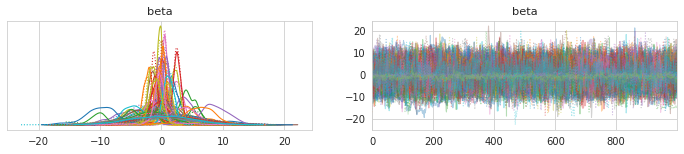

In [117]:
import arviz as az
infr_data = az.from_numpyro(mcmc)
az.plot_trace(infr_data, var_names=["beta"])

In [118]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      1.15      4.28      0.85     -6.16      7.80     44.20      1.00
   beta[1]      0.17      3.31      0.47     -5.25      5.70     18.61      1.08
   beta[2]      0.71      1.77      0.63     -1.89      3.44    838.94      1.00
   beta[3]     -0.13      5.21     -0.18     -8.57      7.92    280.27      1.00
   beta[4]      1.92      3.94      2.97     -5.17      7.10      9.25      1.09
   beta[5]     -1.08      2.27     -1.26     -3.32      1.47    767.89      1.01
   beta[6]      0.03      4.12     -0.42     -7.08      7.37    527.52      1.01
   beta[7]      2.07      5.49      2.22     -6.90     10.73     21.05      1.15
   beta[8]     -0.44      4.07     -0.28     -7.40      5.82     72.65      1.00
   beta[9]     -2.93      2.89     -2.63     -7.38      1.83    188.96      1.00
  beta[10]      1.59      5.07      0.90     -6.35     10.35     18.19      1.13
  beta[11]      2.04      3

In [119]:
gamma_samples = jax.device_get(mcmc.get_samples()["gamma"])
beta_samples = jax.device_get(mcmc.get_samples()["beta"])

In [120]:
from scripts.samplers import generate_potential_energy_fn
gamma_true = np.zeros(p)
gamma_true[np.array(feats[seed_idx]) - 1] = 1
hamm_dist_mixed = np.zeros(gamma_samples.shape[0])
# samples_mi = samples_1.reshape((samples_1.shape[0]*samples_1.shape[1], samples_1.shape[2]))
# hamm_dist_mi = np.zeros(samples_mi.shape[0])
gamma_eng = np.zeros(gamma_samples.shape[0])
sigma = np.cov(beta_samples, rowvar=False)
mean = np.mean(beta_samples, axis=0)
potential_eng = generate_potential_energy_fn(X_train, y_train, J, sigma, 1.0, 1.0, mean)

for i in range(gamma_samples.shape[0]):
    hamm_dist_mixed[i] = hamm(gamma_true, gamma_samples[i])
    gamma_eng[i] = potential_eng(gamma_samples[i], beta_samples[i])


# for i in range(samples_mi.shape[0]):
#     hamm_dist_mi[i] = hamm(gamma_true, samples_mi[i])

# print(f"Mean hamm dist mi: {np.mean(hamm_dist_mi)}")
print(f"Mean hamm dist mixed: {np.mean(hamm_dist_mixed)}")
# print(f"Mean hamm dist mixed: 36.3")

Mean hamm dist mixed: 53.8785


In [121]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, logistic((X_test @ np.mean(beta_samples, axis=0))))

0.4996498599439776

In [44]:
res_auc_mixed = pd.read_csv("data/res_auc_mixed_s_13.csv")

In [23]:
import distrax

mvn = distrax.MultivariateNormalFullCovariance(loc=np.mean(beta_samples, axis=0), covariance_matrix=np.cov(beta_samples, rowvar=False))
mvn.log_prob(beta_samples[0])

DeviceArray(-244.9558, dtype=float32)

In [49]:
%autoreload
from scripts.samplers import rank_hmc_feats_mi, average_length, rank_hmc_feats_rand

feats_hmc_mi, _ = rank_hmc_feats_mi(gamma_samples, beta_samples, X_train, y_train, J, np.cov(beta_samples, rowvar=False), 1.0, 1.0, 1.0, loc=np.mean(beta_samples, axis=0))

In [39]:
average_length(feats_hmc_mi)

54.40521327014218

In [50]:
feats_hmc_rand = rank_hmc_feats_rand(gamma_samples)

In [51]:
res_auc_mixed_2 = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_hmc_rand[:100])

100%|█████████████████████████████████████████| 95/95 [1:02:36<00:00, 39.54s/it, m_tr=0.58, m_te=0.55, l_tr=0.50, l_te=0.50]


In [ ]:
res_auc_mixed_2.describe()

In [40]:
res_auc_mixed_3 = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_hmc_mi[:100])

100%|███████████████████████████████████| 100/100 [1:01:02<00:00, 36.63s/it, m_tr=0.64, m_te=0.45, l_tr=0.51, l_te=0.49]


In [ ]:
feats_hmc_rand_2 = rank_hmc_feats_rand(gamma_samples)
res_auc_mixed_4 = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_hmc_rand_2)
res_auc_mixed_4.to_csv("data/res_auc_mixed_4_s_13.csv", index=False)

 68%|███████████████████████▏          | 67/98 [9:08:45<3:36:17, 418.61s/it, m_tr=0.56, m_te=0.70, l_tr=0.54, l_te=0.49]

In [81]:
feats_hmc_mi_2, _ = rank_hmc_feats_mi(gamma_samples, beta_samples, X_train, y_train, J, np.cov(beta_samples, rowvar=False), 1.0, 1.0, 1.0, np.mean(beta_samples, axis=0))
res_auc_mixed_5 = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_hmc_mi_2[:100])
res_auc_mixed_5.to_csv("data/res_auc_mixed_5_s_13.csv", index=False)

100%|███████████████████████████████████████| 100/100 [1:05:28<00:00, 39.28s/it, m_tr=0.56, m_te=0.66, l_tr=0.52, l_te=0.52]


In [76]:
res_auc_mixed_4.describe()

,moses_cv_score,moses_test_score,log_cv_score,log_test_score
count,98.000000,98.000000,98.000000,98.000000
mean,0.600340,0.623139,0.529476,0.490857
std,0.027793,0.049773,0.014333,0.016694
min,0.527381,0.463235,0.505884,0.478992
25%,0.581111,0.592437,0.520874,0.483193
50%,0.602883,0.624475,0.523671,0.485294
75%,0.620466,0.662027,0.537161,0.487395
max,0.662982,0.719538,0.565447,0.568627


In [82]:
res_auc_mixed_5.describe()

,moses_cv_score,moses_test_score,log_cv_score,log_test_score
count,100.000000,100.000000,100.000000,100.000000
mean,0.607645,0.620266,0.524847,0.493799
std,0.027475,0.045276,0.012865,0.018224
min,0.544064,0.512955,0.505180,0.481092
25%,0.592651,0.590249,0.510784,0.484769
50%,0.608175,0.621499,0.521571,0.487395
75%,0.621327,0.651611,0.536176,0.489496
max,0.675973,0.723039,0.551548,0.568627


In [ ]:
res_auc_mixed_3.describe()

In [48]:
res_auc_mixed.describe()

,moses_cv_score,moses_test_score,log_cv_score,log_test_score
count,100.000000,100.000000,100.000000,100.000000
mean,0.644000,0.613291,0.515588,0.504604
std,0.026741,0.033801,0.013583,0.017586
min,0.568691,0.500700,0.494391,0.485294
25%,0.629510,0.594188,0.508293,0.491597
50%,0.644735,0.615196,0.512188,0.495798
75%,0.662369,0.636380,0.525147,0.527486
max,0.709742,0.688025,0.548984,0.539566


In [359]:
res_auc_mixed_5.describe()

In [ ]:
gamma_eng_idx = np.argsort(gamma_eng)
gamma_eng_samples = gamma_samples[gamma_eng_idx]
feats_eng = samples_to_feats(gamma_eng_samples[:100])
res_auc_mixed_6 = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_eng)
res_auc_mixed_6.to_csv("data/res_auc_mixed_6_s_13.csv", index=False)
res_auc_mixed_6.describe()

100%|████████████████████████████████████████| 97/97 [6:08:54<00:00, 228.19s/it, m_tr=0.65, m_te=0.64, l_tr=0.54, l_te=0.49]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
count,97.000000,97.000000,97.000000,97.000000
mean,0.608524,0.623430,0.524999,0.492622
std,0.027783,0.044685,0.012832,0.017579
min,0.518758,0.523459,0.505180,0.481092
25%,0.594697,0.594538,0.510784,0.483193
50%,0.608180,0.623599,0.521573,0.485294
75%,0.622326,0.656513,0.536176,0.489496
max,0.675973,0.723039,0.551548,0.568627


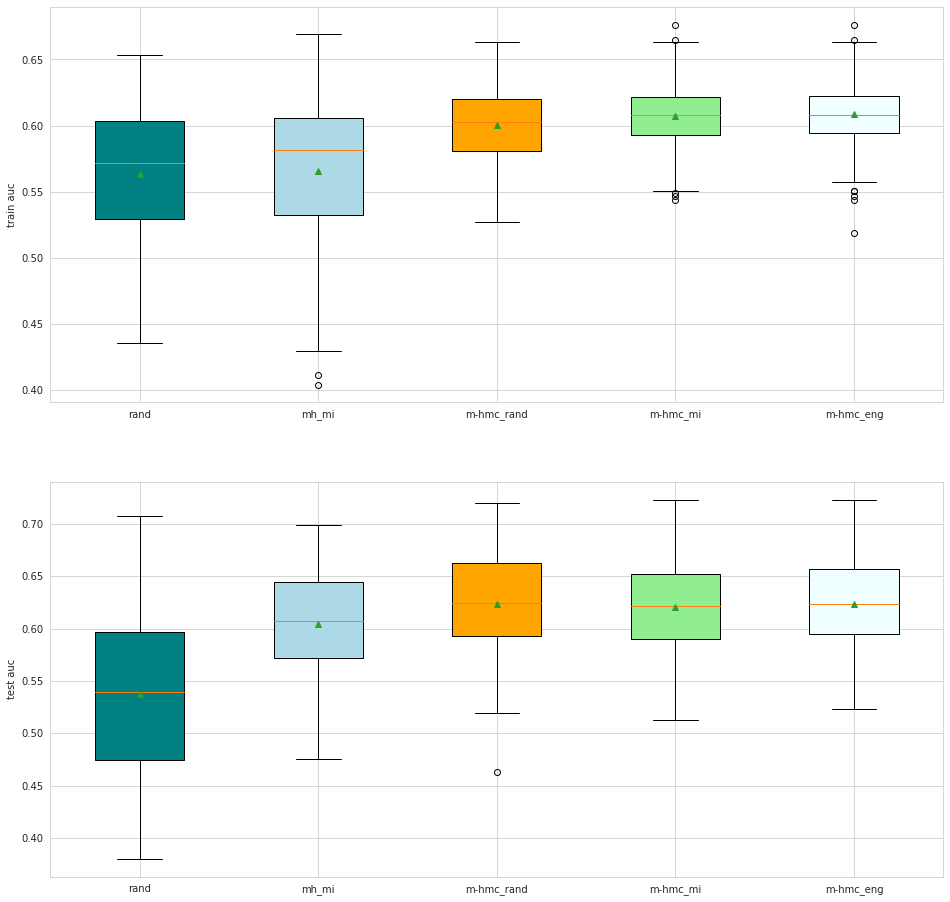

In [111]:
fig, ax = plt.subplots(2, 1, figsize=(16, 16))

colors = ['teal', 'lightblue', 'orange', 'lightgreen', "azure", "wheat"]

train_scores = [res_auc_rand["moses_cv_score"], res_auc_mi["moses_cv_score"],
                res_auc_mixed_4["moses_cv_score"], res_auc_mixed_5["moses_cv_score"], res_auc_mixed_6["moses_cv_score"]]

test_scores = [res_auc_rand["moses_test_score"], res_auc_mi["moses_test_score"],
                res_auc_mixed_4["moses_test_score"],res_auc_mixed_5["moses_test_score"], res_auc_mixed_6["moses_test_score"]]
bplot1 = ax[0].boxplot(train_scores, showmeans=True, labels=["rand", "mh_mi", "m-hmc_rand", "m-hmc_mi", "m-hmc_eng"], patch_artist=True, vert=True)
bplot2 = ax[1].boxplot(test_scores, showmeans=True, labels=["rand", "mh_mi", "m-hmc_rand", "m-hmc_mi", "m-hmc_eng"], patch_artist=True, vert=True)
ax[0].set_ylabel("train auc")
ax[1].set_ylabel("test auc")


for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [113]:
fig.savefig("data/mcmc_boxplot.jpg")

In [114]:
res_auc_mixed

,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.616850,0.617297,0.520477,0.495798
1,0.653112,0.604692,0.495799,0.495798
2,0.658278,0.638305,0.512887,0.495798
3,0.605527,0.608894,0.509003,0.493697
4,0.643464,0.604342,0.512188,0.533263
...,...,...,...,...
95,0.635974,0.529412,0.532972,0.493697
96,0.657238,0.598389,0.497902,0.495798
97,0.667271,0.644608,0.537183,0.531162
98,0.658207,0.657213,0.509391,0.529062


In [7]:
%autoreload
import numpyro as npyro
import numpyro.diagnostics as diagnostics
import distrax

# jax.config.update('jax_platform_name', 'cpu')

from notebooks.variable_selection.mixed_hmc_jax import *

# sigma = 25*np.identity(p)

# beta_dist = distrax.MultivariateNormalFullCovariance(np.zeros(p), sigma)


def draw_samples_mixed_hmc(n_samples, X, y, J,
                           epsilon, total_travel_time, L,
                           n_discrete_to_update, mu=1.0, adaptive_step_size=None,
                           progbar=True, mode='RW'
                           ):
    N, p = X.shape
    potential = jax.jit(generate_potential_energy_fn(X, y, J, mu))
    labels_for_discrete = jax.device_put(np.tile(np.arange(2), (p, 1)))
    beta0 = jax.device_put(np.random.rand(p))
    gamma0 = jax.device_put(np.random.binomial(1, 0.5, size=(p,)))
    key = jax_prng_key()

    gamma_samples, beta_samples, accept_array = mixed_hmc_on_joint(
        q0_discrete=gamma0,
        q0_continuous=beta0,
        n_samples = n_samples,
        epsilon=epsilon,
        total_travel_time=total_travel_time,
        L=L,
        key=key,
        n_discrete_to_update=n_discrete_to_update,
        labels_for_discrete=labels_for_discrete,
        potential=potential,
        mode=mode,
        adaptive_step_size=adaptive_step_size,
        progbar=progbar,
    )

    return gamma_samples, beta_samples, accept_array